Interation 1: error = 1.220469401825324
Interation 2: error = 1.0017626059227234
Interation 3: error = 0.0029327904614454897
Interation 4: error = 1.8146645245995088e-05
Interation 5: error = 7.866509877008972e-11
Interation 6: error = 5.024583610626216e-15
Converged in 6 iterations with error on objective function 7.638334409421077e-14 and error on residue 5.024583610626216e-15
Computed periodic orbit is unstable, maximal Floquet multiplier is 3.5391452696321988


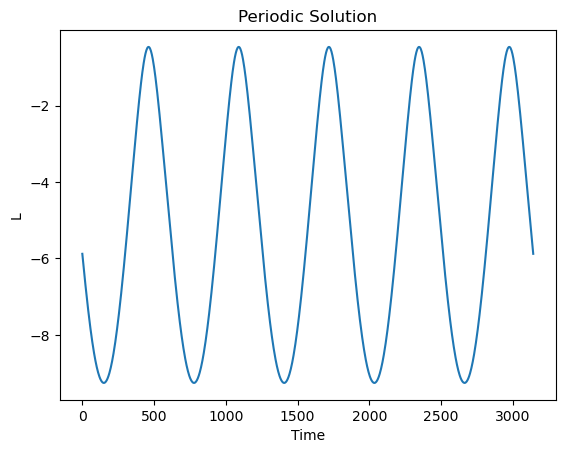

In [3]:
import numpy as np
from scipy.integrate import solve_ivp

def big_system(t, X_aug, f, df, n):
    x = X_aug[:n]
    Phi = X_aug[n:].reshape((n, n), order = 'F')
    
    dxdt = f(x, t)
    dPhidt = df(x, t) @ Phi
    
    return np.concatenate([dxdt, dPhidt.flatten(order = 'F')])

def Newton_orbite_T_known(f, df, x0, T, tol=1e-7, max_iter=50):
    n = len(x0)
    
    for iter in range(max_iter):
        # Integrate ODE over one period and variational equation for Monodromy matrix
        Phi0 = np.eye(n)
        X_aug0 = np.concatenate([x0, Phi0.flatten()])
        
        sol = solve_ivp(lambda t, X: big_system(t, X, f, df, n),
                        [0, T], X_aug0, method='RK45', rtol=1e-5, atol=1e-7)
        
        xT = sol.y[:n, -1]  # Solution at final time
        PhiT = sol.y[n:, -1].reshape((n, n),  order = 'F')  # Monodromy matrix
        
        # Newton correction
        delta_x = np.linalg.solve(np.eye(n) - PhiT, xT - x0)
        
        # Update estimate
        x0 += delta_x

        # Display error at current iteration
        print(f'Interation {iter+1}: error = {np.linalg.norm(delta_x)}')
        
        # Check convergence
        if np.linalg.norm(delta_x) < tol:
            x_periodic = x0
            
            # Integrate ODE over one period and variational equation for Monodromy matrix
            Phi0 = np.eye(n)
            X_aug0 = np.concatenate([x0, Phi0.flatten()])
            
            sol = solve_ivp(lambda t, X: big_system(t, X, f, df, n),
                            [0, T], X_aug0, method='RK45', rtol=1e-5, atol=1e-7)
            
            xT = sol.y[:n, -1]  # Solution at final time
            PhiT = sol.y[n:, -1].reshape((n, n),  order = 'F')  # Monodromy matrix

            
            err_inf = np.max(np.abs(xT - x0))
            
            print(f'Converged in {iter+1} iterations with error on objective function {err_inf} and error on residue {np.linalg.norm(delta_x)}')
            
            # Compute Floquet multipliers
            floquet_mult = np.linalg.eigvals(PhiT)
            max_floquet = np.max(np.abs(floquet_mult))
            
            if max_floquet > 1:
                print(f'Computed periodic orbit is unstable, maximal Floquet multiplier is {max_floquet}')
            else:
                print('Computed periodic orbit is stable')
            
            return x_periodic, err_inf, floquet_mult
    
    print('Newton method did not converge.')

# Modulated laser test case
dim = 2
gamm = 1e-3
A = 1.1
m = 2.5e-2
omeg = 1e-2
f = lambda x, t: np.array([x[1] - 1 - m * np.cos(omeg * t), gamm * (A - x[1] * (1 + np.exp(x[0])))])
df = lambda x, t: np.array([[0, 1], [-gamm * x[1] * np.exp(x[0]), -gamm * (1 + np.exp(x[0]))]])

# Initial guess
L0 = -6.1
D0 = 0.98
x0 = np.array([L0, D0])
T = 2 * np.pi / omeg

# Parameters for Newton iterations
tol = 1e-12
max_iter = 10

# Newton iterations
x_periodic, err_inf, floquet_mult = Newton_orbite_T_known(f, df, x0, T, tol, max_iter)

# Plot of the solution
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
t_eval = np.linspace(0, 5 * T, 1000)
sol = solve_ivp(lambda t, x: f(x, t), [0, 5 * T], x_periodic, t_eval=t_eval, method='RK45', rtol=1e-5, atol=1e-7)
ax.plot(sol.t, sol.y[0])
ax.set_xlabel('Time')
ax.set_ylabel('L')
ax.set_title('Periodic Solution')
plt.show()